In [2]:
%load_ext autoreload
%autoreload 2
%cd ~/dev/neurad-studio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/s0001900/dev/neurad-studio


In [3]:
import typing
from typing import Optional
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionImg2ImgPipeline, UNet2DConditionModel
from diffusers.image_processor import VaeImageProcessor
import torch
from transformers import AutoTokenizer
from transformers import CLIPTextModel


from nerfstudio.generative.diffusion_model import DiffusionModelId
from nerfstudio.scripts.run_train_lora import import_encoder_class_from_model_name_or_path

model_id = DiffusionModelId.sd_v2_1
revision: str = "main"
variant: Optional[str] = None 

device = torch.device("cuda")
dtype = torch.float16



In [4]:
img_processor = VaeImageProcessor()

noise_scheduler = typing.cast(DDPMScheduler, DDPMScheduler.from_pretrained(
    model_id, subfolder="scheduler"
))

unet = typing.cast(UNet2DConditionModel, 
                   UNet2DConditionModel.from_pretrained(
    model_id,
    subfolder="unet",
    revision=revision,
    variant=variant,

))

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
    revision=revision,
    use_fast=False,
)

text_encoder_cls = import_encoder_class_from_model_name_or_path(
    model_id, revision, subfolder="text_encoder"
)

text_encoder = typing.cast(CLIPTextModel, text_encoder_cls.from_pretrained(
    model_id,
    subfolder="text_encoder",
    revision=revision,
    variant=variant,
))

vae = typing.cast(AutoencoderKL, AutoencoderKL.from_pretrained(
    model_id,
    subfolder="vae",
    revision=revision,
    variant=variant,
))

models = {"img_processor": img_processor, "unet": unet, "tokenizer": tokenizer, "text_encoder": text_encoder, "vae": vae}

# TODO: Compile

vae.requires_grad_(False)
vae.to(device=device, dtype=dtype)

unet.requires_grad_(False)
unet.to(device=device, dtype=dtype)

text_encoder.requires_grad_(False)
text_encoder.to(device=device, dtype=dtype)

do_classifier_free_guidance: bool = True

#unet = torch.compile(unet)

...;

/home/s0001900/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


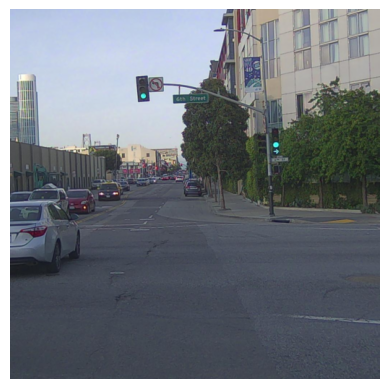

In [5]:
from pathlib import Path
from nerfstudio.generative.dynamic_dataset import make_img_tf_pipe, read_image
from nerfstudio.generative.utils import show_img


ex_img_path = Path("data/pandaset/001/camera/front_camera/00.jpg")
ex_img = read_image(ex_img_path, make_img_tf_pipe(dtype=dtype, crop_type="center"), device=device)
show_img(ex_img)

In [6]:
from nerfstudio.generative.diffusion_model import encode_img


latent = encode_img(img_processor, vae, ex_img, device)
latent.shape

torch.Size([1, 4, 64, 64])

In [7]:
from nerfstudio.generative.diffusion_model import get_ordered_timesteps


with torch.no_grad():
    timesteps = get_ordered_timesteps(0.02, device, num_timesteps=10)

timesteps

tensor([ 1,  3,  6,  7, 10, 11, 13, 16, 18, 20], device='cuda:0')

In [8]:
from nerfstudio.generative.diffusion_model import add_noise_to_latent


noisy_latent = add_noise_to_latent(latent, timesteps[-1], noise_scheduler)
noisy_latent.shape

torch.Size([1, 4, 64, 64])

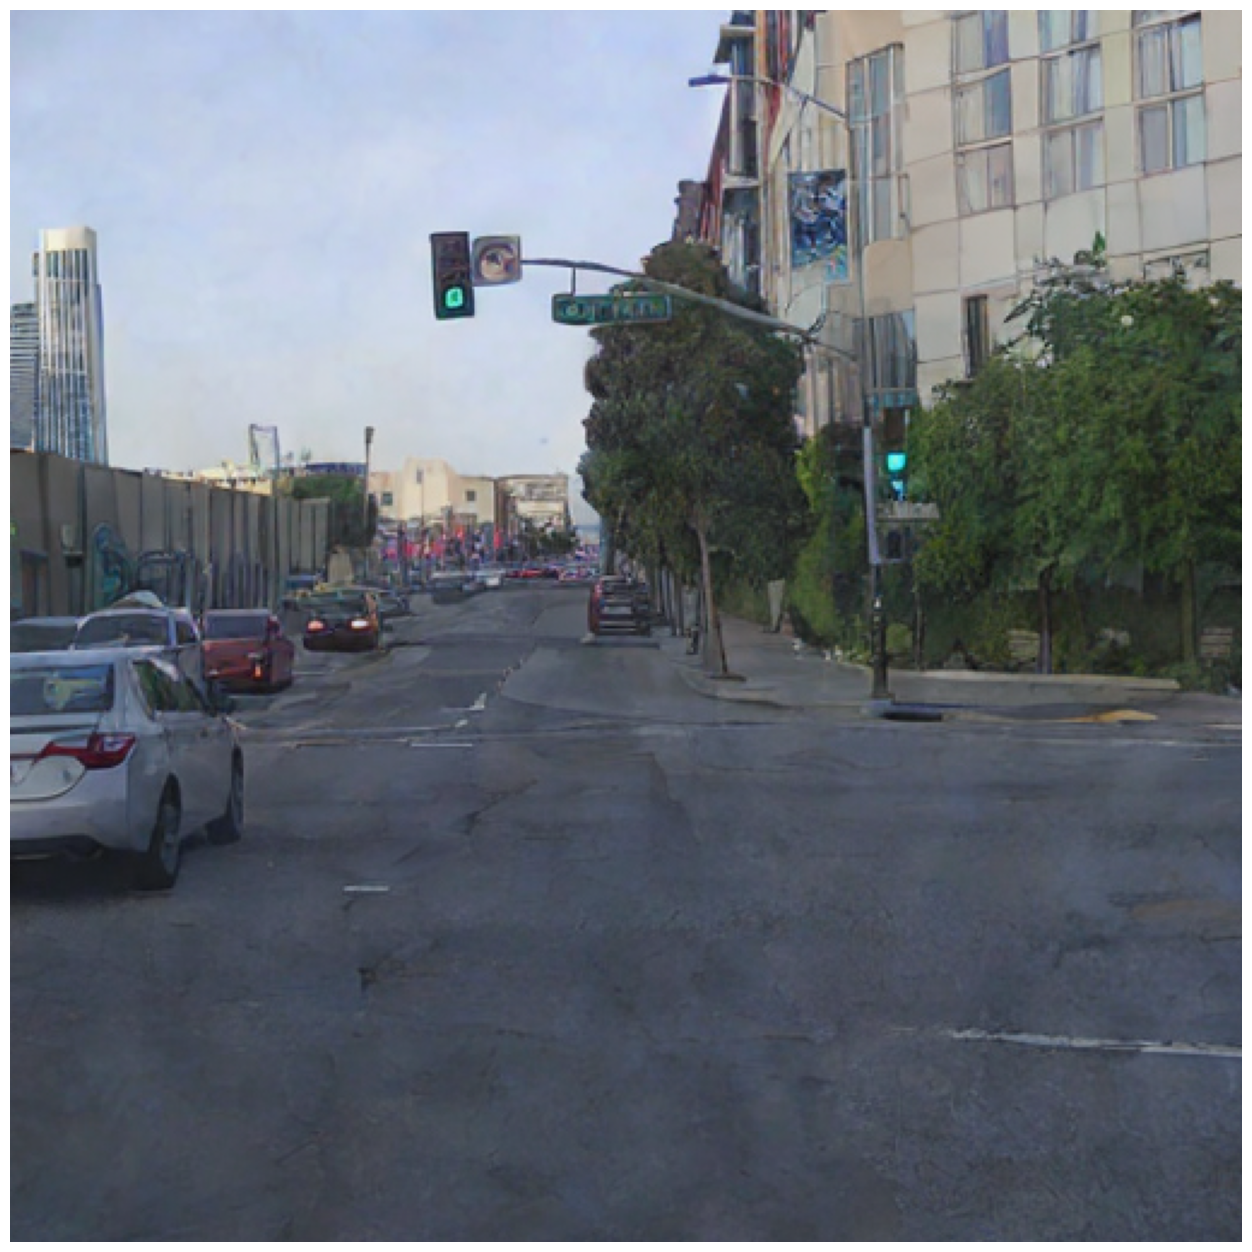

In [9]:
from nerfstudio.generative.diffusion_model import decode_img


with torch.no_grad():
    show_img(decode_img(img_processor, vae, noisy_latent))

In [16]:
from nerfstudio.generative.diffusion_model import embed_prompt


with torch.no_grad():
    prompt_embeds = embed_prompt(tokenizer, text_encoder, "")

if do_classifier_free_guidance:
    prompt_embeds = torch.cat((prompt_embeds, prompt_embeds))

prompt_embeds.shape

torch.Size([2, 77, 1024])

In [17]:
from nerfstudio.generative.diffusion_model import denoise_latent, get_ordered_timesteps


with torch.no_grad():
    denoised_latent = denoise_latent(noisy_latent, unet, timesteps, noise_scheduler, prompt_embeds)

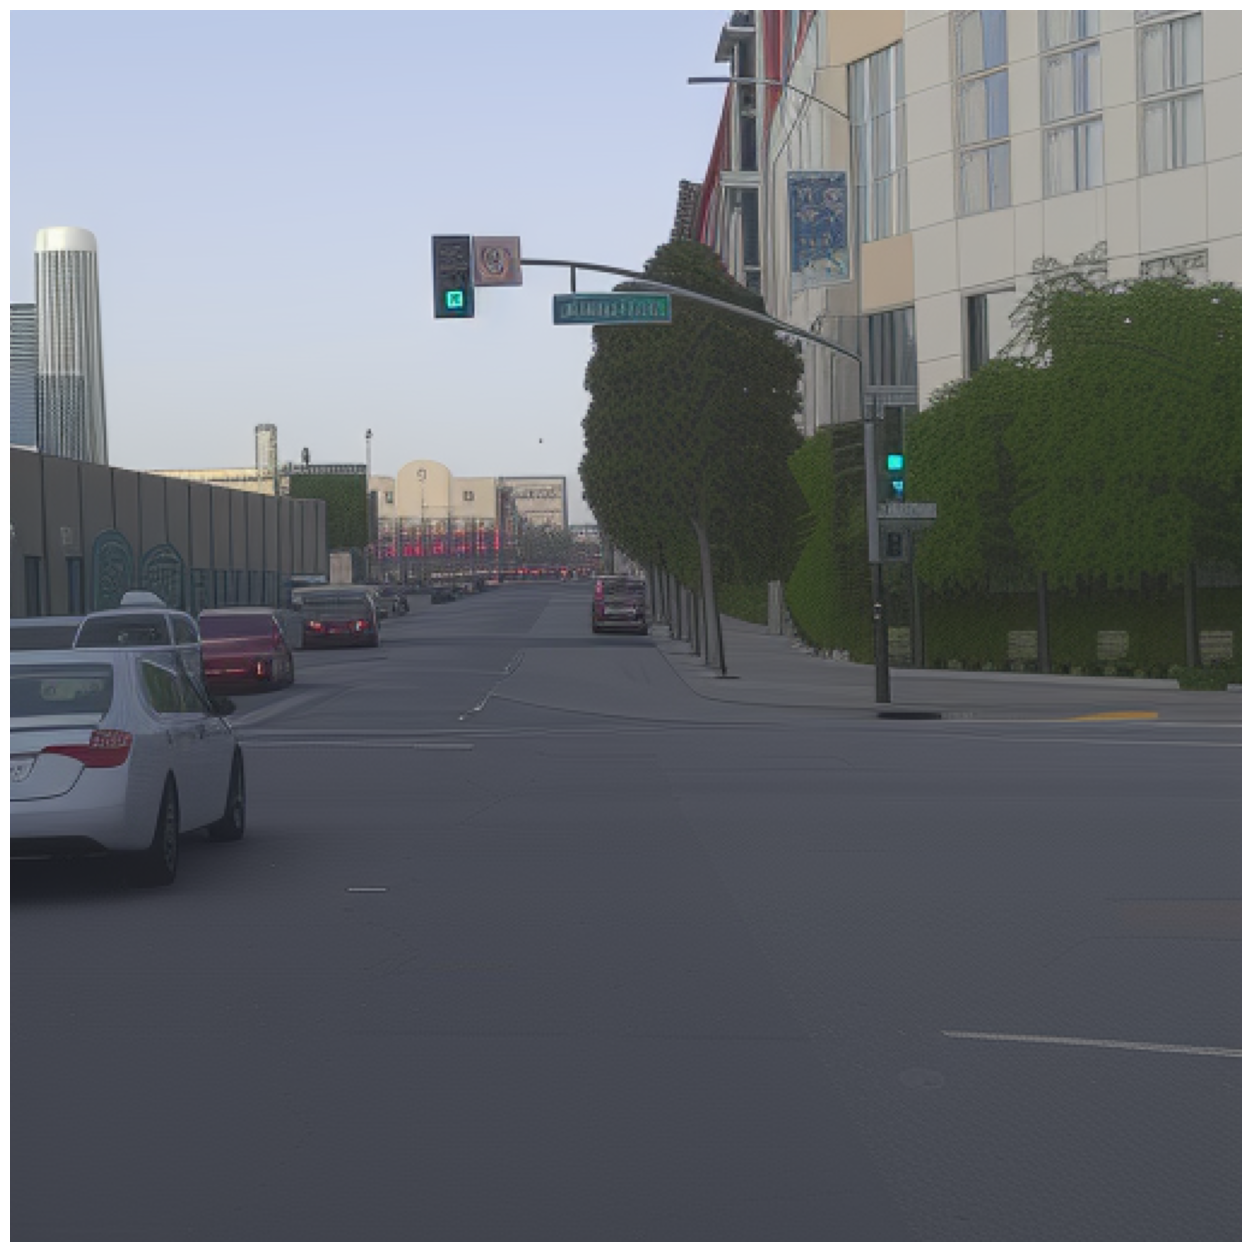

In [18]:
from nerfstudio.generative.diffusion_model import decode_img


with torch.no_grad():
    denoised_img = decode_img(img_processor, vae, denoised_latent)
show_img(denoised_img)

In [13]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id, vae=vae, text_encoder=text_encoder, unet=unet, scheduler=noise_scheduler, safety_checker=None
)
pipe.to(device=device, dtype=dtype)


...;

/home/s0001900/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

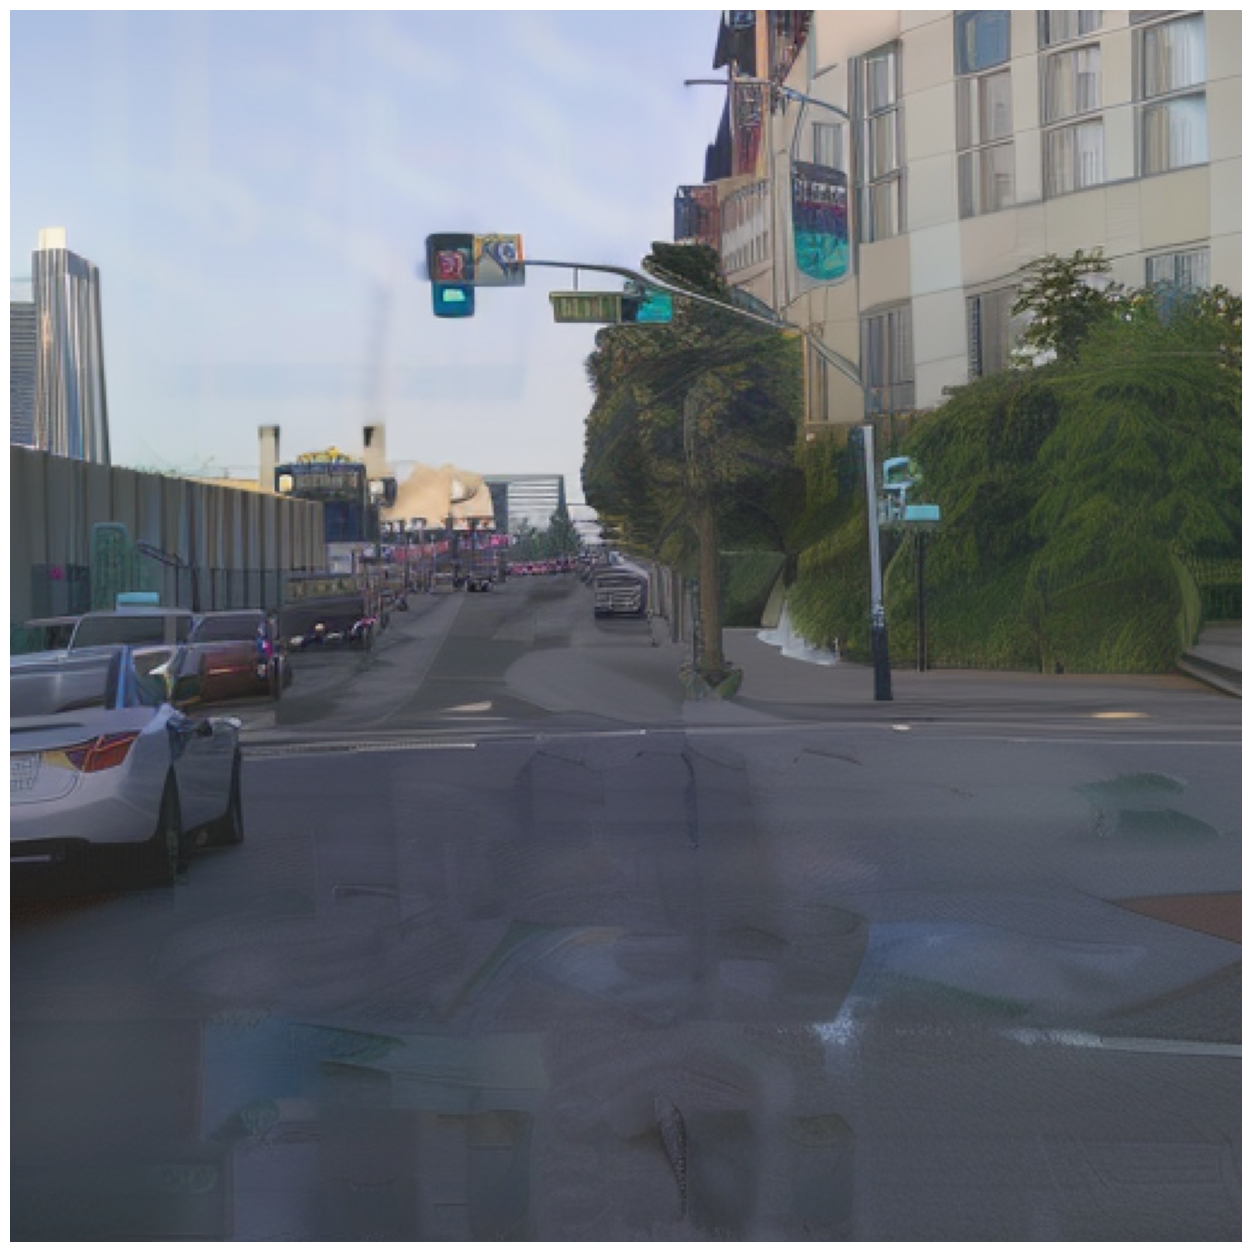

In [14]:
img_out = pipe(image=ex_img, prompt="", strength=0.2, num_inference_steps=50, output_type="pt").images
show_img(img_out)